# A composite electrode particle model

 A composite electrode particle model is developed for (negative) electrodes with two phases, e.g. graphite/silicon in LG M50 battery cells. The current version is demonstrated for negative composite electrodes only but is easily extended to positive composite electrodes. The reference is at the end of this notebook.

## How to use the model

Let us set up pybamm 

In [1]:
#%pip install pybamm -q    # install PyBaMM if it is not installed
import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
from matplotlib import style
style.use('ggplot')
os.chdir(pybamm.__path__[0]+'/..')
pybamm.set_logging_level("INFO")

Choose the function of "BasicDFNComposite()" to load the composite electrode particle model. Then add a set of parameters for the composite including two phases, namely "phase 1" and "phase 2". We can update the values for either phase by calling its name (here phase 1 and 2 represent for graphite and silicon respectively).

In [2]:
start = timeit.default_timer()
model = pybamm.lithium_ion.BasicDFNComposite()
chemistry = pybamm.parameter_sets.Chen2020_composite
param = pybamm.ParameterValues(chemistry=chemistry)

param.update({"Upper voltage cut-off [V]": 4.5})
param.update({"Lower voltage cut-off [V]": 2.5})
param.update({
    "Maximum concentration in negative electrode of phase 1 [mol.m-3]":28700,
    "Initial concentration in negative electrode of phase 1 [mol.m-3]":23000,
    "Negative electrode mass fraction of phase 1":0.98,
    "Negative electrode diffusivity of phase 1 [m2.s-1]":5.5E-14,
    "Negative electrode diffusivity of phase 2 [m2.s-1]":1.67E-14,
    "Negative electrode mass fraction of phase 2":0.02,
    "Initial concentration in negative electrode of phase 2 [mol.m-3]":277000,
    "Maximum concentration in negative electrode of phase 2 [mol.m-3]":278000,
    })

Define a current loading

In [3]:
C_rates = 0.5
Q_cell = 5 # [Ah]
period = 1 / C_rates * Q_cell / 5
transition = period / 20
timestep=np.array([0.1, period * 4]) * 3600
points=[41, 201, 201]
t_evals=[]
t0 = 0
for i in range(0,len(timestep)):
    t1 = np.linspace(t0, t0 + timestep[i] - transition, points[i])
    t0 += timestep[i]
    if i < len(timestep)-1:
        t2 = np.linspace(t0 - transition, t0 + transition, 41) # transition points
    else:
        t2 = []
    t_evals=np.concatenate((t_evals, t1 ,t2))

t_evals = np.unique(t_evals)
capacity = param["Nominal cell capacity [A.h]"]
I_load = C_rates * capacity  

def I_fun(A):
    def current(t):
        C_rates = 0.5
        Q_cell = 5 # [Ah]
        period = 1 / C_rates * Q_cell / 5
        timestep=np.array([0.1, period * 4]) * 3600
        k = 10
        rest = pybamm.sigmoid( t , timestep[0], k)
        discharge = pybamm.sigmoid( t , timestep[0] + timestep[1], k) - rest
        return A * discharge
        # return A * (t < period) - A * (t >= period)
        # return A * 0.2 * pybamm.sin(2 * np.pi * t / 7200 )
    return current

param["Current function [A]"] = I_fun(I_load)

It is very easy to vary the relative volume fraction of each phase. The following example shows how to compare the results of batteries with three relative fractions (0.001, 0.04, 0.1) of phase 2 (silicon).

In [4]:
v_si=[0.001,0.04,0.1]
solution=[]
for i in range(len(v_si)):
    param.update({
        "Negative electrode mass fraction of phase 1":1 - v_si[i],
        "Negative electrode mass fraction of phase 2":v_si[i],
    })
    print(v_si[i])
    sim = pybamm.Simulation(
        model,
        parameter_values=param,
        solver=pybamm.CasadiSolver(dt_max = 10),
    )
    solution.append(sim.solve(t_eval = t_evals))
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

2022-02-25 16:36:31,298 - [INFO] parameter_values.process_model(415): Start setting parameters for Doyle-Fuller-Newman model
2022-02-25 16:36:31,438 - [INFO] parameter_values.process_model(518): Finish setting parameters for Doyle-Fuller-Newman model
2022-02-25 16:36:31,439 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model


0.001


2022-02-25 16:36:31,660 - [INFO] discretisation.process_model(254): Finish discretising Doyle-Fuller-Newman model
2022-02-25 16:36:31,661 - [INFO] base_solver.solve(815): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2022-02-25 16:36:31,663 - [INFO] base_solver.set_up(111): Start solver set-up
2022-02-25 16:36:31,791 - [INFO] base_solver.set_up(678): Finish solver set-up
At t = 0.00804063 and h = 5.19527e-12, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0.00202966 and h = 1.11037e-12, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00202687 and h = 2.53243e-13, the corrector convergence failed repeatedly or with |h| = hmin.
2022-02-25 16:36:34,181 - [INFO] base_solver.solve(1088): Finish solving Doyle-Fuller-Newman model 

0.04


2022-02-25 16:36:34,583 - [INFO] discretisation.process_model(254): Finish discretising Doyle-Fuller-Newman model
2022-02-25 16:36:34,584 - [INFO] base_solver.solve(815): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2022-02-25 16:36:34,585 - [INFO] base_solver.set_up(111): Start solver set-up
2022-02-25 16:36:34,761 - [INFO] base_solver.set_up(678): Finish solver set-up
2022-02-25 16:36:35,785 - [INFO] base_solver.solve(1088): Finish solving Doyle-Fuller-Newman model (event: Minimum voltage)
2022-02-25 16:36:35,785 - [INFO] base_solver.solve(1089): Set-up time: 176.776 ms, Solve time: 955.077 ms (of which integration time: 754.600 ms), Total time: 1.132 s
2022-02-25 16:36:35,796 - [INFO] parameter_values.process_model(415): Start setting parameters for Doyle-Fuller-Newman model
2022-02-25 16:36:35,919 - [INFO] parameter_values.process_model(518): Finish setting parameters for Doyle-Fuller-Newman model
2022-02-25 16:36:35,920 - [INFO] discretisation.proces

0.1


2022-02-25 16:36:36,167 - [INFO] discretisation.process_model(254): Finish discretising Doyle-Fuller-Newman model
2022-02-25 16:36:36,167 - [INFO] base_solver.solve(815): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2022-02-25 16:36:36,169 - [INFO] base_solver.set_up(111): Start solver set-up
2022-02-25 16:36:36,325 - [INFO] base_solver.set_up(678): Finish solver set-up
At t = 0.00760278 and h = 4.37063e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00119384, , mxstep steps taken before reaching tout.
At t = 0.00119384 and h = 1.66818e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00119384, , mxstep steps taken before reaching tout.
At t = 0.000392719 and h = 2.73854e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000392714 and h = 1.48343e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00019244 and h = 5.07032e-17, the corrector conve

running time: 16.610282579998966s


## Results
Compare the cell voltages of the three cells in this example, to see how silicon affects the output capacity

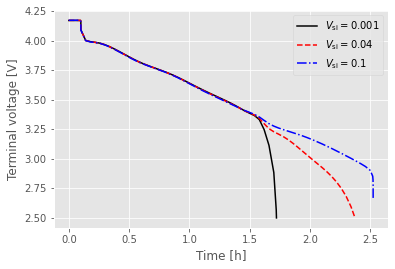

In [5]:
ltype=['k-','r--','b-.','g:','m-','c--','y-.'];
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    V_i = solution[i]["Terminal voltage [V]"].entries
    plt.plot(t_i, V_i,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Terminal voltage [V]')
plt.legend()

Results of interfacial current density in silicon

Text(0.5, 1.0, 'Silicon')

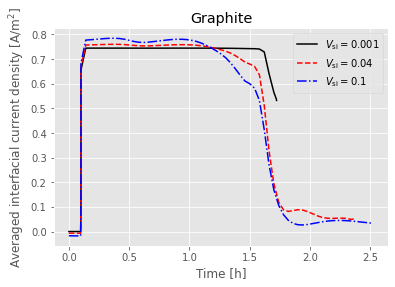

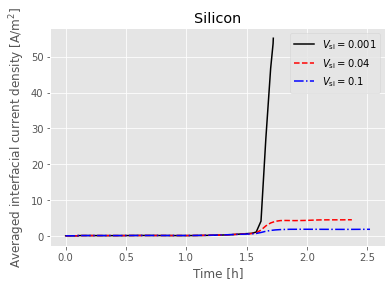

In [6]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p1_av = solution[i]["X-averaged negative electrode interfacial current density of phase 1 [A.m-2]"].entries
    plt.plot(t_i, j_n_p1_av,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged interfacial current density [A/m$^{2}$]')
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p2_av = solution[i]["X-averaged negative electrode interfacial current density of phase 2 [A.m-2]"].entries
    plt.plot(t_i, j_n_p2_av,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged interfacial current density [A/m$^{2}$]')
plt.legend()
plt.title('Silicon')

Results of interfacial current density in graphite

Text(0.5, 1.0, 'Silicon')

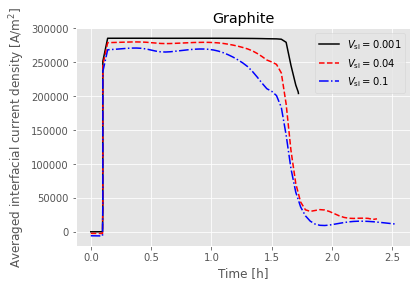

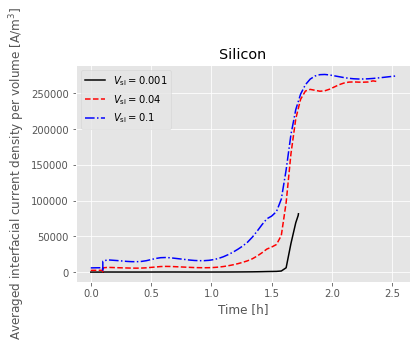

In [7]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p1_Vav = solution[i]["X-averaged negative electrode interfacial current density of phase 1 per volume [A.m-3]"].entries
    plt.plot(t_i, j_n_p1_Vav,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged interfacial current density [A/m$^{2}$]')
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p2_Vav = solution[i]["X-averaged negative electrode interfacial current density of phase 2 per volume [A.m-3]"].entries
    plt.plot(t_i, j_n_p2_Vav,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel('Averaged interfacial current density per volume [A/m$^{3}$]')
plt.legend()
plt.title('Silicon')

Results of average lithium concentration

Text(0.5, 1.0, 'Silicon')

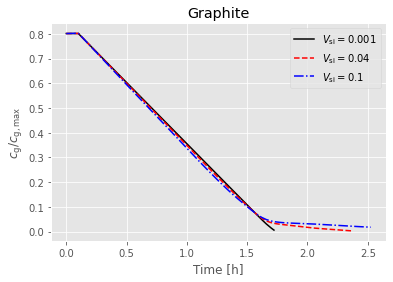

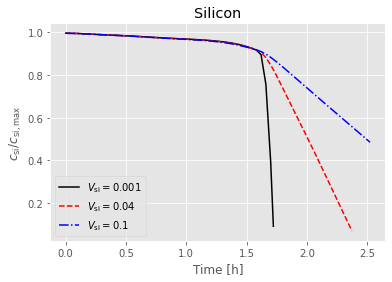

In [8]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    c_s_xrav_n_p1 = solution[i]["Averaged negative electrode concentration of phase 1"].entries
    plt.plot(t_i, c_s_xrav_n_p1 ,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("$c_\mathrm{g}/c_\mathrm{g,max}$")
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    c_s_xrav_n_p2 = solution[i]["Averaged negative electrode concentration of phase 2"].entries
    plt.plot(t_i, c_s_xrav_n_p2,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("$c_\mathrm{si}/c_\mathrm{si,max}$")
plt.legend()
plt.title('Silicon')

Results of equilibrium potential

Text(0.5, 1.0, 'NMC811')

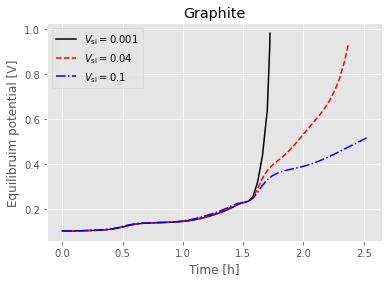

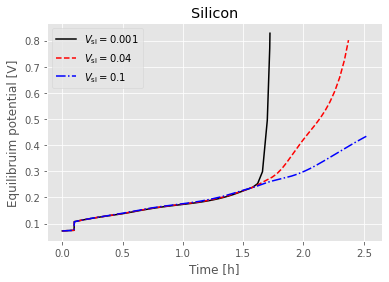

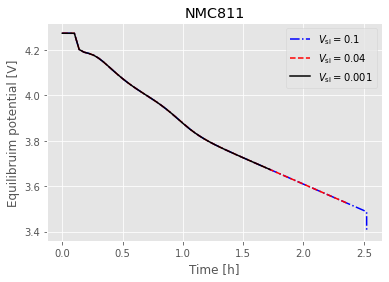

In [7]:
plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    ocp_p1 = solution[i]["X-averaged negative electrode open circuit potential of phase 1 [V]"].entries
    plt.plot(t_i, ocp_p1 ,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title('Graphite')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    ocp_p2 = solution[i]["X-averaged negative electrode open circuit potential of phase 2 [V]"].entries
    plt.plot(t_i, ocp_p2,ltype[i],label="$V_\mathrm{si}=$"+str(v_si[i]))
plt.xlabel('Time [h]')
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title('Silicon')

plt.figure()
for i in range(0,len(v_si)):
    t_i = solution[len(v_si)- 1 - i]["Time [s]"].entries / 3600
    ocp_p = solution[len(v_si)- 1 - i]["X-averaged positive electrode open circuit potential [V]"].entries
    plt.plot(t_i, ocp_p,ltype[len(v_si)- 1 - i],label="$V_\mathrm{si}=$"+str(v_si[len(v_si)- 1 - i]))
plt.xlabel('Time [h]')
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title('NMC811')

Reference:

W. Ai, N. Kirkaldy, Y. Jiang, G. Offer, H. Wang, B. Wu (2022). A composite electrode model for lithium-ion battery with a silicon/graphite negative electrode. Journal of Power Sources. 527, 231142.